In [1]:
import numpy as np
from collections import defaultdict
from gym import spaces

import ipywidgets
from ipywidgets import interact
from IPython.display import Image

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Categorical

from rllib.environment.mdps import EasyGridWorld
from rllib.policy import TabularPolicy
from rllib.value_function import TabularQFunction, TabularValueFunction
from rllib.util.neural_networks.utilities import one_hot_encode
from matplotlib import rcParams
rcParams['font.size'] = 12

rcParams['figure.figsize'] = (20, 8)


C:\Users\Thomas\git\uzh\rllib\venv\lib\site-packages\scipy\special\orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import (exp, inf, pi, sqrt, floor, sin, cos, around, int,
C:\Users\Thomas\git\uzh\rllib\venv\lib\site-packages\scipy\sparse\sputils.py:16: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
C:\Users\Thomas\git\uzh\rllib\venv\lib\site-packages\scipy\linalg\__init__.py:217: DeprecationWarning: The module numpy.dual is de

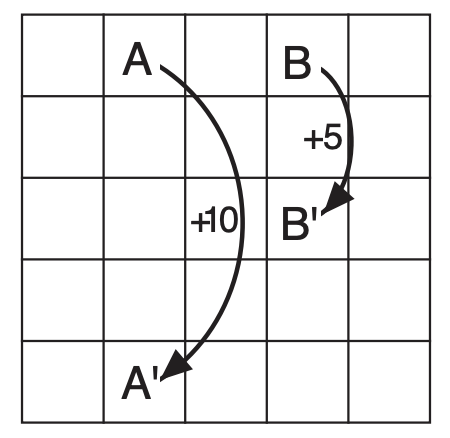

In [2]:
def extract_policy(q_function):
    """Extract a policy from the q_function."""
    policy = TabularPolicy(num_states=q_function.num_states, num_actions=q_function.num_actions)
    for state in range(policy.num_states):
        q_val = q_function(torch.tensor(state).long())
        action = torch.argmax(q_val)

        policy.set_value(state, action)

    return policy

def integrate_q(q_function, policy):
    value_function = TabularValueFunction(num_states = q_function.num_states)
    for state in range(policy.num_states):
        state = torch.tensor(state).long()
        pi = Categorical(logits=policy(state))
        value = 0
        for action in range(policy.num_actions):
            value += pi.probs[action] * q_function(state, torch.tensor(action).long())

        value_function.set_value(state, value)

    return value_function

environment = EasyGridWorld()
Image("grid_world.png")

In [3]:
# Plotters
def plot_value_function(value_function, ax):
    ax.imshow(value_function)
    rows, cols = value_function.shape
    for i in range(rows):
        for j in range(cols):
            ax.text(j, i, f"{value_function[i, j]:.1f}", ha="center", va="center", color="w")

def plot_policy(policy, ax):
    def action2str(action):
        if action == 0:  # Down
            return "D"
        elif action == 1:  # Up
            return "U"
        elif action == 2:  # Right
            return "R"
        elif action == 3:  # Left
            return "L"
        elif action == 4:  # Down Right
            return "DR"
        elif action == 5:  # Up Right
            return "UR"
        elif action == 6:  # Down Left
            return "DL"
        elif action == 7:  # Up Left
            return "UL"

    ax.imshow(np.zeros_like(policy))
    rows, cols = policy.shape
    for i in range(rows):
        for j in range(cols):
            ax.text(j, i, action2str(policy[i,j ]), ha="center", va="center", color="r")

def plot_value_and_policy(value_function, policy):
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

    plot_value_function(value_function, axes[0])
    plot_policy(policy, axes[1])


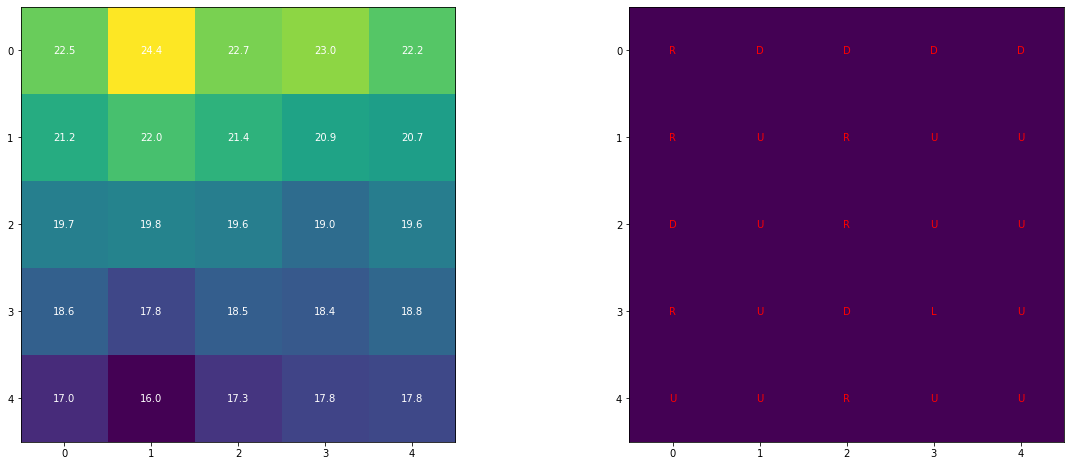

In [4]:
q_function = TabularQFunction(num_states=environment.num_states, num_actions=environment.num_actions)
nn.init.ones_(q_function.nn.head.weight)
gamma = 0.9
alpha = 0.5

# Optimistic Initialization.
q_function.nn.head.weight.data = 10 / (1 - gamma) * q_function.nn.head.weight.data

eps = 0.

state = environment.reset()

for i in range(int(1e4)):
#     eps = eps * 0.999
    if np.random.rand() < eps:
        action = np.random.choice(environment.num_actions)
    else:
        action = torch.argmax(q_function(torch.tensor(state).long())).item()

    q_val = q_function(torch.tensor(state).long(), torch.tensor(action).long())

    next_state, reward, done, info = environment.step(action)

    next_q = torch.max(q_function(torch.tensor(next_state).long()))
    td = reward.item() + gamma * next_q - q_val

    q_function.set_value(state, action, q_val + alpha * td)

    state = next_state

policy = extract_policy(q_function)
value_function = integrate_q(q_function, policy)

plot_value_and_policy(value_function.table.reshape(5, 5).detach().numpy(),
                  policy.table.argmax(0).reshape(5, 5).detach().numpy())
plt.show()


In [5]:
# Planning
def init_value_function(num_states, terminal_states=None):
    """Initialize value function."""
    value_function = TabularValueFunction(num_states)
    terminal_states = [] if terminal_states is None else terminal_states
    for terminal_state in terminal_states:
        value_function.set_value(terminal_state, 0)

    return value_function


In [6]:
def iterative_policy_evaluation(environment, policy, gamma, eps=1e-6, max_iter=1000, value_function=None):
    """Implement Policy Evaluation algorithm (policy iteration without max).

    Parameters
    ----------
    policy: TabularPolicy
    gamma: float
        discount factor.
    eps: float
        desired precision.
    max_iter: int
        Max number of iterations.
    value_function: TabularValueFunction, optional.
        Initial value function.

    Returns
    -------
    value_function: TabularValueFunction
        Value function associated to Policy.
    num_iter: int
        Number of iterations to reach `eps' accuracy.

    References
    ----------
    Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction.
    MIT press.
    Chapter 4.1

    """
    if value_function is None:
        # value_function = init_value_function(environment.num_states)
        value_function = TabularValueFunction(num_states=environment.num_states)

    for num_iter in range(max_iter):
        max_error = 0
        avg_error = 0
        for state in range(environment.num_states):
#             if state in environment.terminal_states:
#                 continue

            value_estimate = torch.tensor(0.0)
            state = torch.tensor(state).long()
            policy_ = Categorical(logits=policy(state))

            for action in np.where(policy_.probs.detach().numpy())[0]:
                p_action = policy_.probs[action].item()

                # In RL, we do not have access to environment.transitions, but only to samples of it!.
                for transition in environment.transitions[(state.item(), action)]:
                    next_state = torch.tensor(transition["next_state"]).long()
                    value_estimate += (
                        p_action
                        * transition["probability"]
                        * (transition["reward"] + gamma * value_function(next_state).item())
                    )

            value = value_function(state)
            error = torch.abs(value_estimate - value).item()
            max_error = max(max_error, error)
            avg_error += error
            value_function.set_value(state, value_estimate)

        if max_error < eps:
            break
    return value_function, num_iter


def interactive_iterative_policy_evaluation(gamma):
    policy = TabularPolicy(num_states=environment.num_states, num_actions=environment.num_actions)
    value_function, num_iter = iterative_policy_evaluation(environment, policy, gamma)

    print(f"Converged after {num_iter}, iterations")

    plot_value_and_policy(value_function.table.reshape(5, 5).detach().numpy(),
                      policy.table.argmax(0).reshape(5, 5).detach().numpy())
    plt.show()

interact(
    interactive_iterative_policy_evaluation,
    gamma=ipywidgets.FloatSlider(value=0.9, min=0, max=0.99, step=1e-3, continuous_update=False)
);

C:\Users\Thomas\git\uzh\rllib\venv\lib\site-packages\ipykernel\pylab\backend_inline.py:13: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  DeprecationWarning,


interactive(children=(FloatSlider(value=0.9, continuous_update=False, description='gamma', max=0.99, step=0.00…